##### This notebook examines some heat flux and temperature diagnostics.

In [1]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.optimize import curve_fit
from xhistogram.xarray import histogram

from dask.distributed import Client

%matplotlib inline

In [2]:
client = Client(n_workers=8)
display(client)

Client Scheduler: tcp://127.0.0.1:35137 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 8 Memory: 128.85 GB


In [3]:
### Generate new database

db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt_spinup500.db'

session = cc.database.create_session(db)

In [4]:
cc.querying.get_experiments(session)

,experiment,ncfiles
0,1deg_jra55_ryf_cont,24764
1,1deg_jra55_ryf_rcp45warm_x1_spinup500,42426
2,1deg_jra55_ryf_rcp45cool_x1_spinup500,42426
3,1deg_jra55_ryf_warm_0sat_8dwlw_spinup500,21206
4,1deg_jra55_ryf_warm_1.5sat_0dwlw_spinup500,21206
5,1deg_jra55_ryf_RCPwarm_humid_x1,42426
6,1deg_jra55_ryf_RCPwarm_humid_x2,42207
7,1deg_jra55_ryf_RCPcool_humid_x1,42207
8,1deg_jra55_ryf_RCPcool_humid_x2,4010
9,1deg_jra55_ryf_wcwc_step_test1,2108


In [5]:
# pd.set_option("display.max_rows", None, "display.max_columns", None)

# cc.querying.get_variables(session, experiment='1deg_jra55_ryf_cont')

## Surface heat fluxes

In [5]:
### Surface heat flux
# Using 'net_sfc_heating': "surface ocean heat flux coming through coupler and mass transfer"

yr_beg = '2400-01-01'
yr_end = '2449-12-31'
var = 'net_sfc_heating'

expt = '1deg_jra55_ryf_cont'
net_sfc_cont = cc.querying.getvar(expt, var, session).sel(time = slice(yr_beg, yr_end)).chunk(chunks='auto') 

expt = '1deg_jra55_ryf_rcp45cool_spinup500'
net_sfc_cool = cc.querying.getvar(expt, var, session).sel(time = slice(yr_beg, yr_end)).chunk(chunks='auto')

expt = '1deg_jra55_ryf_rcp45warm_spinup500'
net_sfc_warm = cc.querying.getvar(expt, var, session).sel(time = slice(yr_beg, yr_end)).chunk(chunks='auto')

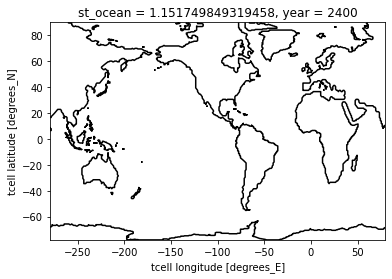

In [6]:
# Get land mask

temp_cont = cc.querying.getvar(expt, 'temp', session, frequency = '1 monthly')
dset = xr.merge([temp_cont.groupby('time.year').mean(dim='time').isel(year = 0, st_ocean = 0)])
ds = dset
mask_ocean = 2 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isfinite(ds.temp)  
mask_land = 1 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isnan(ds.temp)  
mask_array = mask_ocean + mask_land
mask_array.plot.contour(colors = 'k', levels = [2])

Text(0, 0.5, 'Jm$^{-2}$')

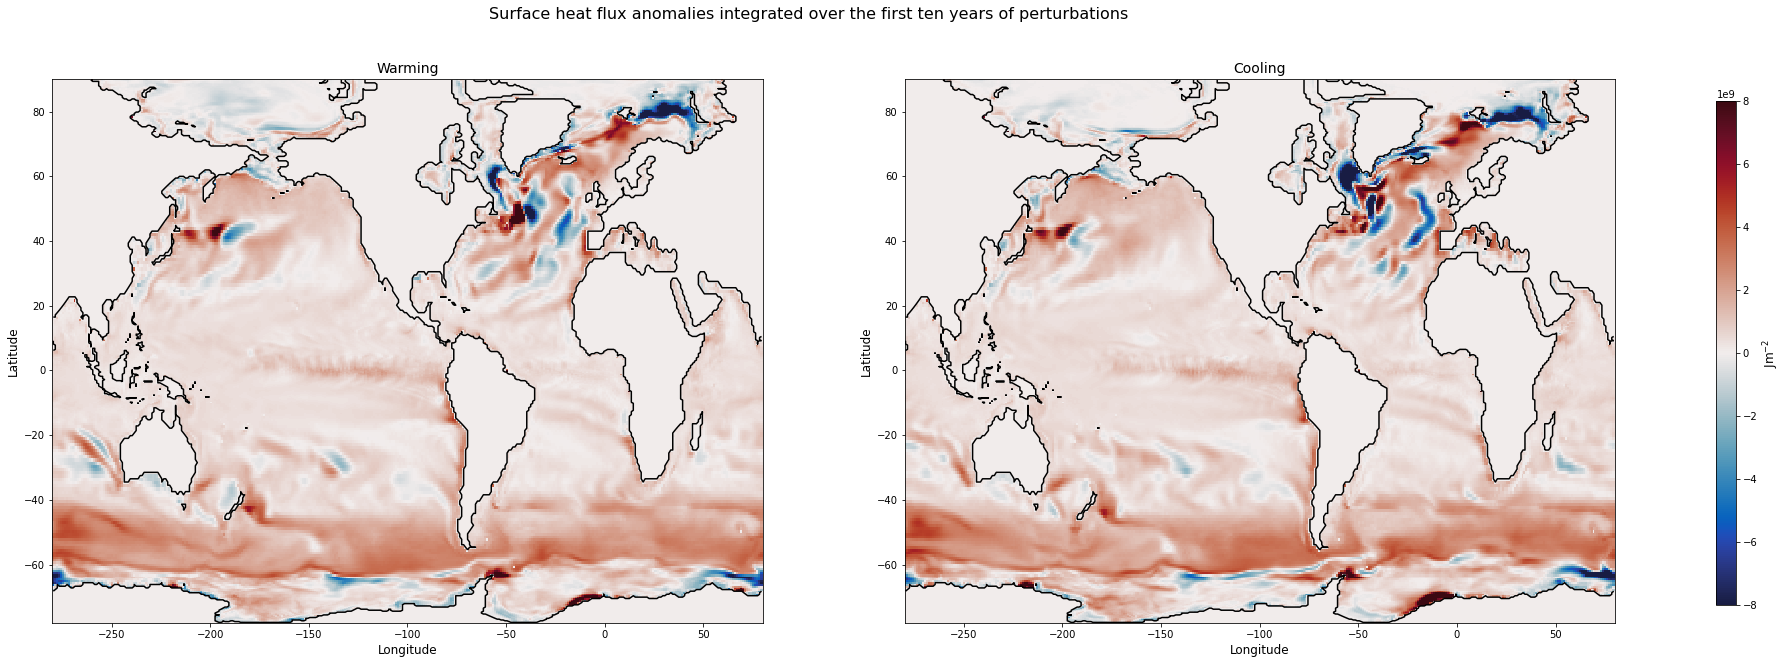

In [7]:
## First decade

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(28, 10))
plt.suptitle('Surface heat flux anomalies integrated over the first ten years of perturbations', fontsize=16)
yr_beg = '2400-01-01'
yr_end = '2409-12-31'

month_length = net_sfc_cont.time.dt.days_in_month
p1 = ((net_sfc_warm - net_sfc_cont) * month_length * 24 * 3600).sel(time = slice(yr_beg, yr_end)).sum('time').plot(ax = axs[0], cmap = cm.cm.balance, vmin = -8e9, vmax = 8e9, add_colorbar = False)
mask_array.plot.contour(colors = 'k', levels = [2], ax = axs[0])
axs[0].set_title('Warming', fontsize=14)
axs[0].set_ylabel('Latitude', fontsize=12)
axs[0].set_xlabel('Longitude', fontsize=12)

p2 = ((-1*net_sfc_cool - -1*net_sfc_cont) * month_length * 24 * 3600).sel(time = slice(yr_beg, yr_end)).sum('time').plot(ax = axs[1], cmap = cm.cm.balance, vmin = -8e9, vmax = 8e9, add_colorbar = False)
mask_array.plot.contour(colors = 'k', levels = [2], ax = axs[1])
axs[1].set_title('Cooling', fontsize=14)
axs[1].set_ylabel('Latitude', fontsize=12)
axs[1].set_xlabel('Longitude', fontsize=12)

cb_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
cbar = fig.colorbar(p2, cax = cb_ax)
cbar.ax.set_ylabel('Jm$^{-2}$', fontsize = 12)
#plt.savefig('SHF_10.jpg')

Text(0, 0.5, 'Jm$^{-2}$')

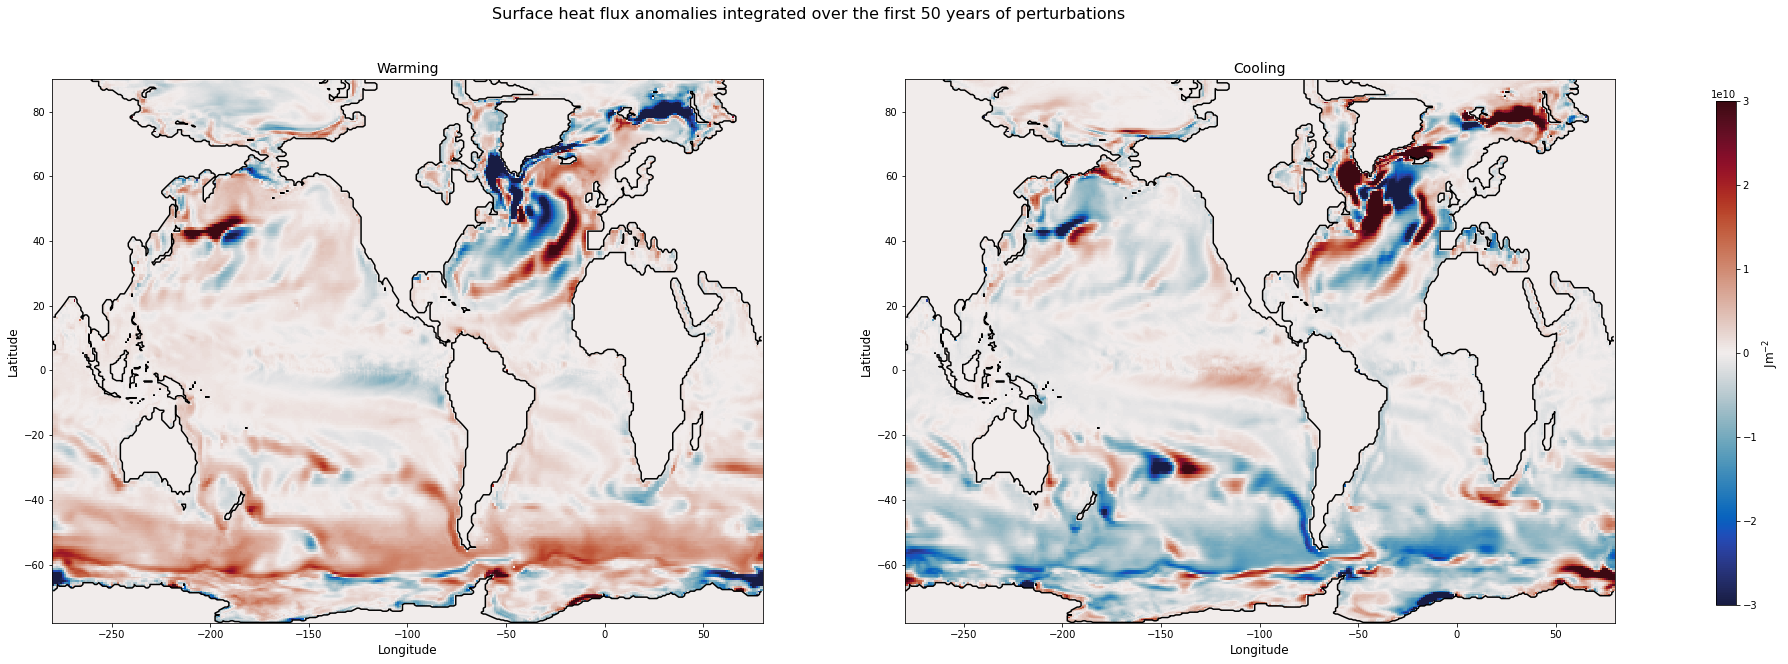

In [8]:
### 50 year perturbation

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(28, 10))
plt.suptitle('Surface heat flux anomalies integrated over the first 50 years of perturbations', fontsize=16)
yr_beg = '2400-01-01'
yr_end = '2449-12-31'

month_length = net_sfc_cont.time.dt.days_in_month
p1 = ((net_sfc_warm - net_sfc_cont) * month_length * 24 * 3600).sel(time = slice(yr_beg, yr_end)).sum('time').plot(ax = axs[0], cmap = cm.cm.balance, vmin = -3e10, vmax = 3e10, add_colorbar = False)
mask_array.plot.contour(colors = 'k', levels = [2], ax = axs[0])
axs[0].set_title('Warming', fontsize=14)
axs[0].set_ylabel('Latitude', fontsize=12)
axs[0].set_xlabel('Longitude', fontsize=12)

p2 = ((net_sfc_cool - net_sfc_cont) * month_length * 24 * 3600).sel(time = slice(yr_beg, yr_end)).sum('time').plot(ax = axs[1], cmap = cm.cm.balance, vmin = -3e10, vmax = 3e10, add_colorbar = False)
mask_array.plot.contour(colors = 'k', levels = [2], ax = axs[1])
axs[1].set_title('Cooling', fontsize=14)
axs[1].set_ylabel('Latitude', fontsize=12)
axs[1].set_xlabel('Longitude', fontsize=12)

cb_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
cbar = fig.colorbar(p2, cax = cb_ax)
cbar.ax.set_ylabel('Jm$^{-2}$', fontsize = 12)
#plt.savefig('SHF_50.jpg')

Text(0, 0.5, 'Latitude')

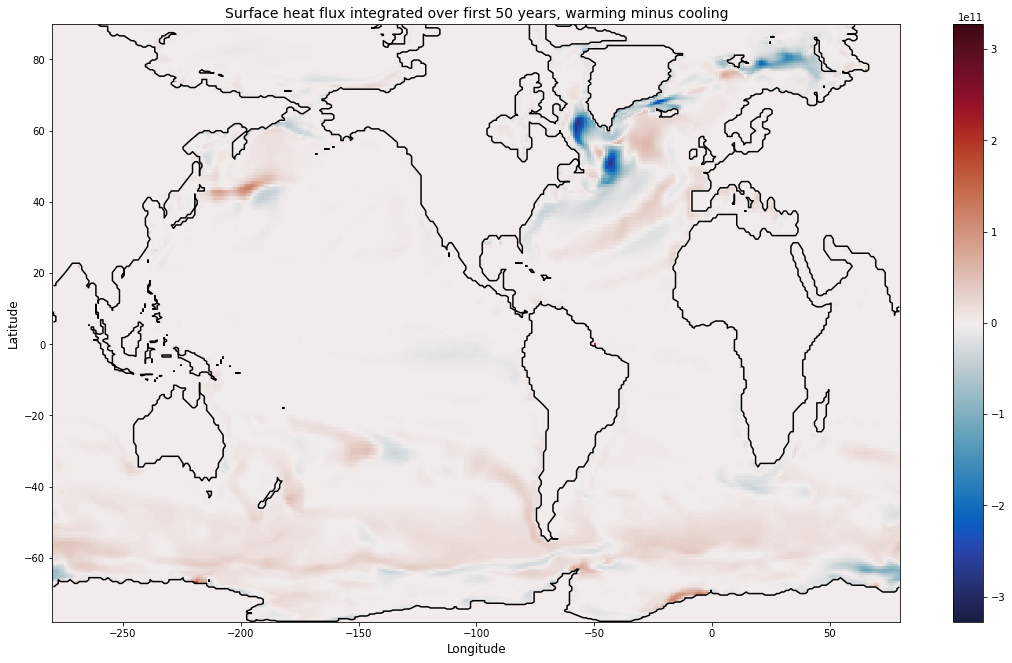

In [9]:
# Difference between warming and cooling

plt.figure(figsize=(19,11))

yr_beg = '2400-01-01'
yr_end = '2449-12-31'

month_length = net_sfc_cont.time.dt.days_in_month
difference = net_sfc_warm - net_sfc_cool
(difference * month_length * 24 * 3600).sel(time = slice(yr_beg, yr_end)).sum('time').plot(cmap = cm.cm.balance)
mask_array.plot.contour(colors = 'k', levels = [2])
plt.title('Surface heat flux integrated over first 50 years, warming minus cooling', fontsize=14)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

### True Zonal Mean

Calculate the *true zonal mean* of a scalar quantity regardless of the horizontal mesh. 

Specifically, we calculate the volume weighted mean along all grid cells whose centres fall within finite latitude intervals rather than the arithmetic mean of cells along the model's curvilinear grid. The method presented can also be used to re-grid models onto the same latitudinal grid and the general principles can be used to define any multidimensional sum or average using the `xhistogram` package.
    
**Requirements:** 
Select the `conda/analysis3-20.01` (or later) kernel.
This code should work for just about any MOM5 configuration since all we are grabbing is temeprature and standard grid information. You can swap temperature with any other scalar variable. You can also in principle swap latitude with another scalar.

Last updated by Jan Zika 8-4-2020

The main issue with a standard arithmetic mean is the 'latitude' coordinate may be meaningless near the north pole, particulalrly when comparing to observational analysis or other models which will have either a regular grid or a different curvilinear grid. Even different versions of MOM might have different grids. 

Let us consider what the true zonal average looks like. That is consider a set of latitude 'edges' $\{\phi'_{1/2},\phi'_{1+1/2},...,\phi'_{\ell-1/2},\phi'_{\ell+1/2},...,\phi'_{L+1/2}\}$ between which we want to compute an average of $T$ at $\{\phi'_{1},\phi'_{2},...,\phi'_{\ell},...,\phi'_{L}\}$ such that

$$ \overline{T}(\phi'_\ell,\sigma) = \dfrac{\iint_{\phi'_{\ell-1/2} < \phi \leq \phi'_{\ell+1/2}} T(\phi,\lambda,\sigma)\frac{\partial z}{\partial \sigma}(\phi,\lambda,\sigma)\,\mathrm{d}A}{\iint_{\phi'_{\ell-1/2} < \phi \leq \phi'_{\ell+1/2}}\frac{\partial z}{\partial \sigma}(\phi,\lambda,\sigma)\,\mathrm{d}A},$$

where $\lambda$ is longitude and $\sigma$ is an arbitrary vertical coordinate. 

In discrete form this average is

$$\overline{T}_{\ell,k} = \frac{\sum_{i=1}^{I}\sum_{j=1}^{J}\delta_{i,j}T_{i,j,k}\Delta Z_{i,j,k}\Delta Area_{i,j}}{\sum_{i=1}^{I}\sum_{j=1}^{J}\delta_{i,j,k}\Delta Z_{i,j,k}\Delta Area_{i,j}},$$

where $\delta_{i,j} = 1$ if $\phi'_{\ell-1/2}<\phi_{i,j}\leq \phi'_{\ell+1/2}$ and $\delta_{i,j} = 0$ elsewhere, $\Delta Z$ is the grid cell vertical thickness and $\Delta Area$ is the grid cell horizontal area.

For our purposes we will use the edges of the model's `xt_ocean` coordinate to define $\phi'_{\ell+1/2}$ so the number of 'bins' $L$ will be the same as the length of the quasi-latitude coordinate ($J$). 

Fortunately, as you can see below, the two sums are weighted histograms (one for $T$ times volume and the other for just volume) and these can be rapidly computed using `xhistogram`.

First let's load the scalar variable (latitude) we want to use as our coordinate then define the bin edges.

In [10]:
# yr_beg = '2400-01-16'

# expt = '1deg_jra55_ryf_cont'
# temp_cont = cc.querying.getvar(expt, 'temp', session, frequency = '1 monthly').sel(time = slice(yr_beg, None)).chunk(chunks='auto')
# for i in range(1,10):
#     da = cc.querying.getvar('output11{}'.format(i), 'temp', session, frequency = '1 monthly')
#     temp_cont = xr.concat([temp_cont, da], dim = 'time') # I have to do this loop because the years 2455 onwards are stored as different experiments in this session, annoyingly... To fix.
    
# expt = '1deg_jra55_ryf_rcp45cool_spinup500'
# temp_cool = cc.querying.getvar(expt, 'temp', session, frequency = '1 monthly').chunk(chunks='auto') 

# expt = '1deg_jra55_ryf_rcp45warm_spinup500'
# temp_warm = cc.querying.getvar(expt, 'temp', session, frequency = '1 monthly').chunk(chunks='auto')

In [10]:
# Surface heat flux zonally averaged, cooling

yr_beg = '2400-01-01'
yr_end = '2449-12-31'

variable_to_average = (net_sfc_cool - net_sfc_cont).sel(time = slice(yr_beg, yr_end))
coord = 'geolat_t' #can be any scalar (2D, 3D, eulerian, lagrangian etc)
expt = '1deg_jra55_ryf_rcp45cool_spinup500'
variable_as_coord = cc.querying.getvar(expt, coord, session, n=1) #might need ncfile='ocean.nc' if a tracer
yu_ocean = cc.querying.getvar(expt, 'yu_ocean', session, n=1)
bins =  np.insert(yu_ocean.values, 0, np.array(-90), axis=0) 
dzt = cc.querying.getvar(expt, 'dzt', session).sel(time = slice(yr_beg, yr_end)) #thickness of cells
dzt_monthly = xr.DataArray(dzt.isel(st_ocean = 0).values, dims=['time','yt_ocean','xt_ocean'],
                           coords={'time': variable_to_average.time,
                                   'yt_ocean':dzt.yt_ocean,
                                   'xt_ocean': dzt.xt_ocean}) # I want only the surface cell for surface flux purposes.
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt_monthly * area_t) #Volume of cells

histVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins = [bins], weights = dVol, dim = ['yt_ocean', 'xt_ocean'])
histTVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins = [bins], weights = dVol * variable_to_average, dim = ['yt_ocean', 'xt_ocean'])
net_sfc_cool_anom_zonal = (histTVolCoordDepth / histVolCoordDepth)

In [12]:
# Surface heat flux zonally averaged, warming

yr_beg = '2400-01-01'
yr_end = '2449-12-31'

variable_to_average = (net_sfc_warm - net_sfc_cont).sel(time = slice(yr_beg, yr_end))
coord = 'geolat_t' #can be any scalar (2D, 3D, eulerian, lagrangian etc)
expt = '1deg_jra55_ryf_rcp45warm_spinup500'
variable_as_coord = cc.querying.getvar(expt, coord, session, n=1)
yu_ocean = cc.querying.getvar(expt, 'yu_ocean', session, n=1)
bins =  np.insert(yu_ocean.values, 0, np.array(-90), axis=0) 
dzt = cc.querying.getvar(expt, 'dzt', session).sel(time = slice(yr_beg, yr_end)) #thickness of cells
dzt_monthly = xr.DataArray(dzt.isel(st_ocean = 0).values, dims=['time','yt_ocean','xt_ocean'],
                           coords={'time': variable_to_average.time,
                                   'yt_ocean':dzt.yt_ocean,
                                   'xt_ocean': dzt.xt_ocean}) # I want only the surface cell for surface flux purposes.
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt_monthly * area_t) #Volume of cells

histVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins = [bins], weights = dVol, dim = ['yt_ocean', 'xt_ocean'])
histTVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins = [bins], weights = dVol * variable_to_average, dim = ['yt_ocean', 'xt_ocean'])
net_sfc_warm_anom_zonal = (histTVolCoordDepth / histVolCoordDepth)

Text(0, 0.5, 'Time averaged surface heat flux')

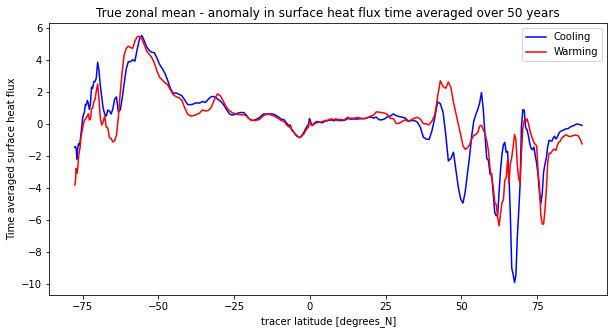

In [15]:
plt.figure(figsize=(10, 5))

(-1*net_sfc_cool_anom_zonal).mean('time').plot(label = 'Cooling', color = 'b')

net_sfc_warm_anom_zonal.mean('time').plot(label = 'Warming', color = 'r')

plt.title('True zonal mean - anomaly in surface heat flux time averaged over 50 years')
plt.legend()
plt.ylabel('Time averaged surface heat flux')
#plt.savefig('figures/surfzonal')

### Vertically integrated heat content

In [13]:
rho_0 = 1030 #kg/m^3
c_p = 3992 #J/kg/K

yr_beg = '2400-01-01'
yr_end = '2449-12-31'

In [14]:
# Control

expt = '1deg_jra55_ryf_cont'
var1 = 'temp'
darray1 = cc.querying.getvar(expt, var1, session, start_time = yr_beg).sel(time=slice(yr_beg,yr_end))
var2 = 'dzt'
darray2 = cc.querying.getvar(expt, var2, session, start_time = yr_beg).sel(time=slice(yr_beg,yr_end))
var3 = 'area_t'
darray3 = cc.querying.getvar(expt, var3, session, n=1)
vertically_integrated_heat_cont = (rho_0 * c_p * darray1 * darray2).sum('st_ocean')

In [15]:
# Cool, and true zonal mean

expt = '1deg_jra55_ryf_rcp45cool_spinup500'
var1 = 'temp'
darray1 = cc.querying.getvar(expt, var1, session, start_time = yr_beg).sel(time=slice(yr_beg,yr_end))
var2 = 'dzt'
darray2 = cc.querying.getvar(expt, var2, session, start_time = yr_beg).sel(time=slice(yr_beg,yr_end))
var3 = 'area_t'
darray3 = cc.querying.getvar(expt, var3, session,n=1)
vertically_integrated_heat_cool = (rho_0 * c_p * darray1 * darray2).sum('st_ocean')

variable_to_average = (vertically_integrated_heat_cool - vertically_integrated_heat_cont)
coord = 'geolat_t' #can be any scalar (2D, 3D, eulerian, lagrangian etc)
variable_as_coord = cc.querying.getvar(expt, coord, session, n=1) #might need ncfile='ocean.nc' if a tracer
yu_ocean = cc.querying.getvar(expt, 'yu_ocean', session, n=1)
bins =  np.insert(yu_ocean.values, 0, np.array(-90), axis=0) 
dzt = cc.querying.getvar(expt, 'dzt', session).sel(time = slice(yr_beg, yr_end)).isel(st_ocean = 0) #thickness of cells

area_t = cc.querying.getvar(expt, 'area_t', session, n=1) #area of cells
dVol = (dzt * area_t) #Volume of cells

histVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins = [bins], weights = dVol, dim = ['yt_ocean', 'xt_ocean'])
histTVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins = [bins], weights = dVol * variable_to_average, dim = ['yt_ocean', 'xt_ocean'])
coord_mean_cool = (histTVolCoordDepth / histVolCoordDepth).groupby('time.year').sum(dim='time')

In [16]:
# Warm, and true zonal mean

expt = '1deg_jra55_ryf_rcp45warm_spinup500'
var1 = 'temp'
darray1 = cc.querying.getvar(expt, var1, session, start_time = yr_beg).sel(time=slice(yr_beg,yr_end))
var2 = 'dzt'
darray2 = cc.querying.getvar(expt, var2, session, start_time = yr_beg).sel(time=slice(yr_beg,yr_end))
var3 = 'area_t'
darray3 = cc.querying.getvar(expt, var3, session,n=1)
vertically_integrated_heat_warm = (rho_0 * c_p * darray1 * darray2).sum('st_ocean')

variable_to_average = (vertically_integrated_heat_warm - vertically_integrated_heat_cont)
coord = 'geolat_t' #can be any scalar (2D, 3D, eulerian, lagrangian etc)
variable_as_coord = cc.querying.getvar(expt, coord, session, n=1) #might need ncfile='ocean.nc' if a tracer
yu_ocean = cc.querying.getvar(expt, 'yu_ocean', session, n=1)
bins =  np.insert(yu_ocean.values, 0, np.array(-90), axis=0) 
dzt = cc.querying.getvar(expt, 'dzt', session).sel(time = slice(yr_beg, yr_end)).isel(st_ocean = 0) #thickness of cells

area_t = cc.querying.getvar(expt, 'area_t', session, n=1) #area of cells
dVol = (dzt * area_t) #Volume of cells

histVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins = [bins], weights = dVol, dim = ['yt_ocean', 'xt_ocean'])
histTVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins = [bins], weights = dVol * variable_to_average, dim = ['yt_ocean', 'xt_ocean'])
coord_mean_warm = (histTVolCoordDepth / histVolCoordDepth).groupby('time.year').sum(dim='time')

In [37]:
heat_warm = (vertically_integrated_heat_warm).mean(dim = ['xt_ocean', 'yt_ocean']).groupby('time.year').mean(dim='time').load()
heat_cool = (vertically_integrated_heat_cool).mean(dim = ['xt_ocean', 'yt_ocean']).groupby('time.year').mean(dim='time').load()
heat_cont = (vertically_integrated_heat_cont).mean(dim = ['xt_ocean', 'yt_ocean']).groupby('time.year').mean(dim='time').load()

In [40]:
vertically_integrated_heat_cont

<xarray.DataArray (time: 600, yt_ocean: 300, xt_ocean: 360)>
dask.array<sum-aggregate, shape=(600, 300, 360), dtype=float64, chunksize=(1, 150, 180), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * time      (time) object 2400-01-16 12:00:00 ... 2449-12-16 12:00:00

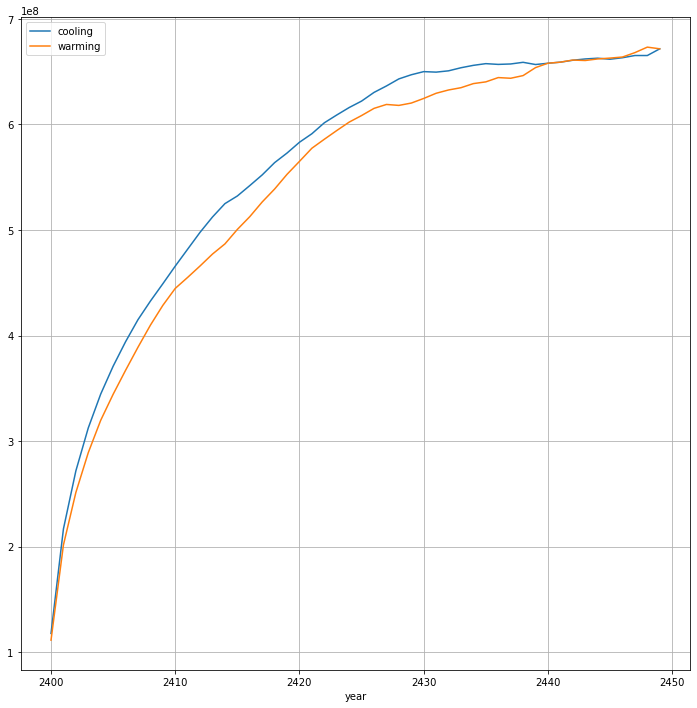

In [38]:
plt.figure(figsize=(12,12))

(-1*heat_cool - -1*heat_cont).plot(label='cooling')
(heat_warm - heat_cont).plot(label='warming')
plt.grid()
plt.legend()

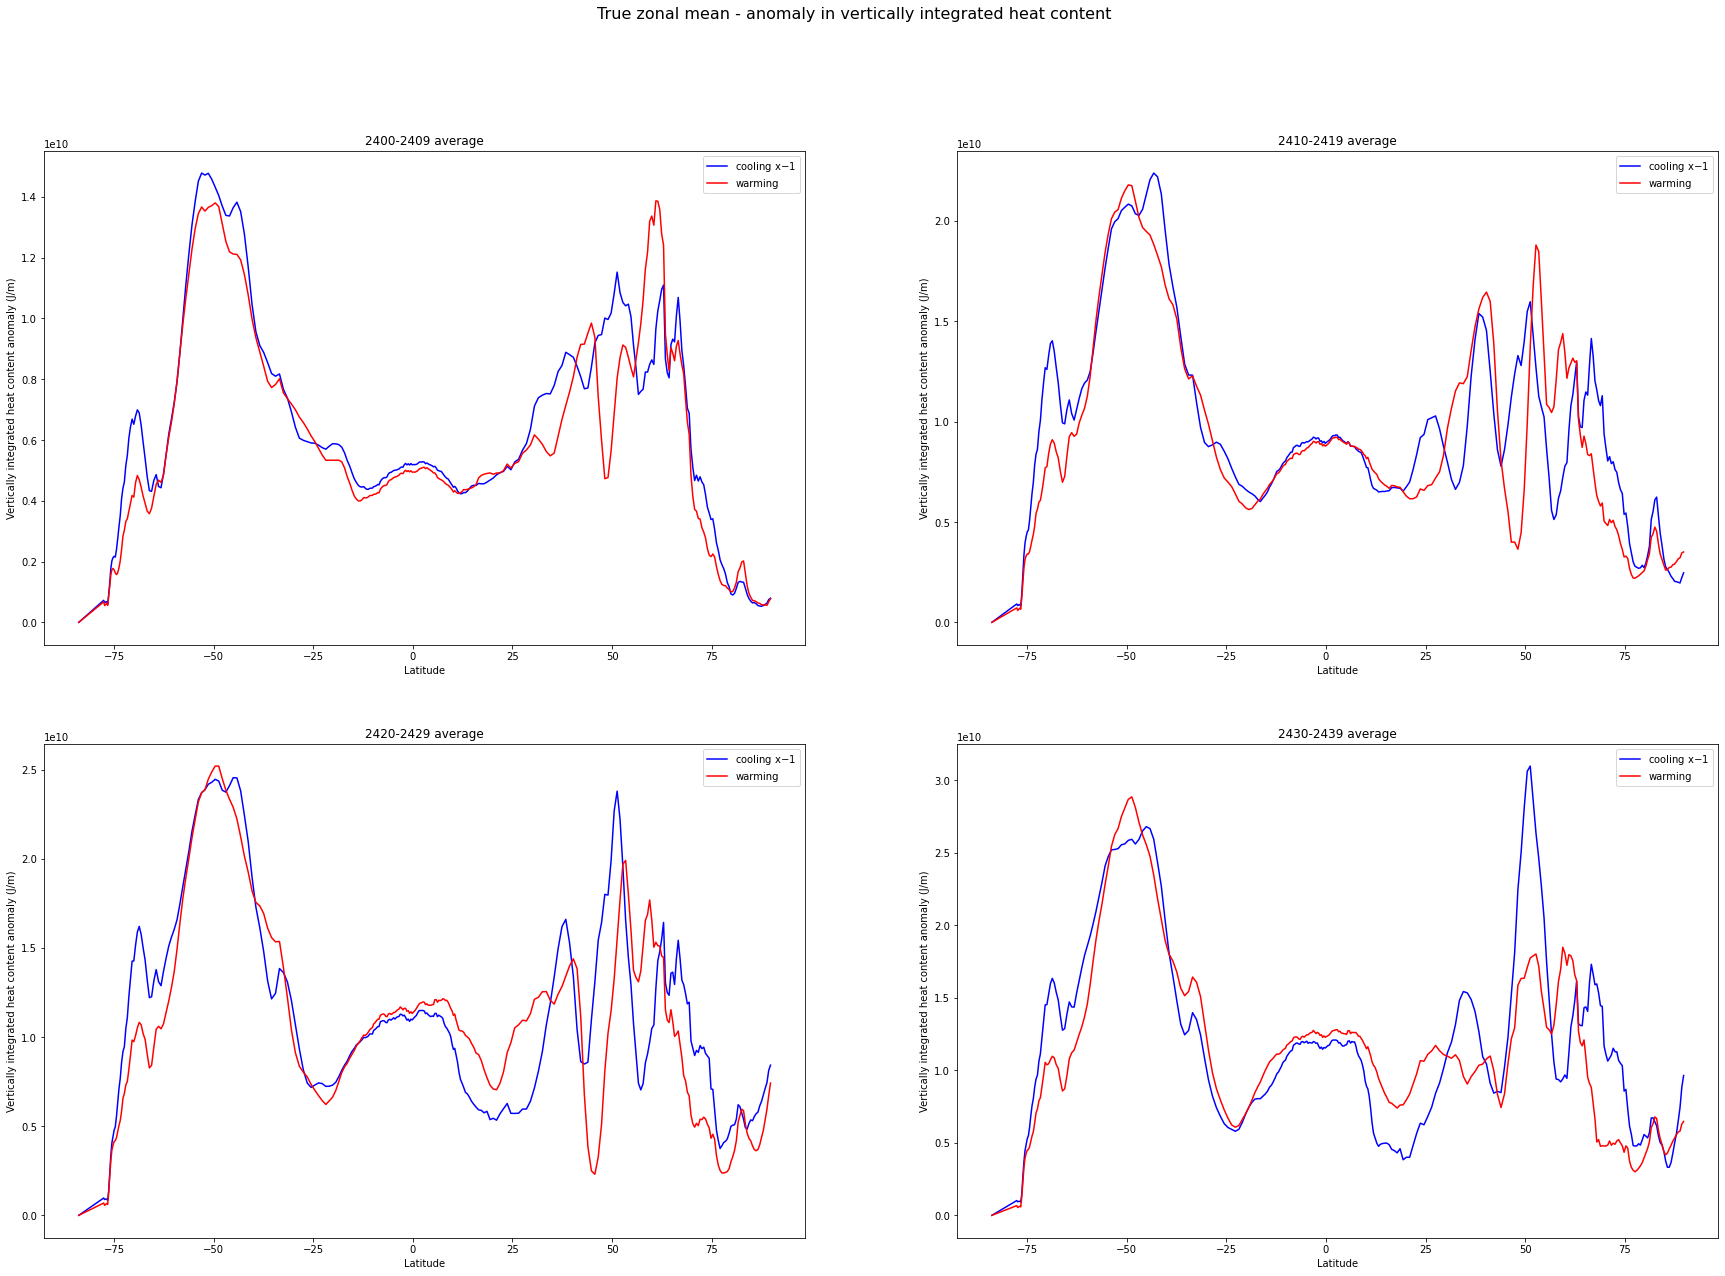

In [79]:
# Vertically integrated heat content time averages over different periods

### Would be good to plot side by sides for different decades,
# e.g., 2400-2410, 2410-2420, 2420-2430, 2430-2440.

fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (30, 20))
plt.suptitle('True zonal mean - anomaly in vertically integrated heat content', fontsize=16)

(-1*coord_mean_cool).sel(year=slice(2400, 2409)).mean('year').plot(ax = axs[0, 0], label = 'cooling x$-1$', color = 'b')
coord_mean_warm.sel(year=slice(2400, 2409)).mean('year').plot(ax = axs[0, 0], label = 'warming', color = 'r')
axs[0, 0].legend()
axs[0, 0].set_title('2400-2409 average', fontsize=12)
axs[0, 0].set_ylabel('Vertically integrated heat content anomaly (J/m)')
axs[0, 0].set_xlabel('Latitude')

(-1*coord_mean_cool).sel(year=slice(2410, 2419)).mean('year').plot(ax = axs[0, 1], label = 'cooling x$-1$', color = 'b')
coord_mean_warm.sel(year=slice(2410, 2419)).mean('year').plot(ax = axs[0, 1], label = 'warming', color = 'r')
axs[0, 1].legend()
axs[0, 1].set_title('2410-2419 average', fontsize=12)
axs[0, 1].set_ylabel('Vertically integrated heat content anomaly (J/m)')
axs[0, 1].set_xlabel('Latitude')

(-1*coord_mean_cool).sel(year=slice(2420, 2429)).mean('year').plot(ax = axs[1, 0], label = 'cooling x$-1$', color = 'b')
coord_mean_warm.sel(year=slice(2420, 2429)).mean('year').plot(ax = axs[1, 0], label = 'warming', color = 'r')
axs[1, 0].legend()
axs[1, 0].set_title('2420-2429 average', fontsize=12)
axs[1, 0].set_ylabel('Vertically integrated heat content anomaly (J/m)')
axs[1, 0].set_xlabel('Latitude')

(-1*coord_mean_cool).sel(year=slice(2430, 2439)).mean('year').plot(ax = axs[1, 1], label = 'cooling x$-1$', color = 'b')
coord_mean_warm.sel(year=slice(2430, 2439)).mean('year').plot(ax = axs[1, 1], label = 'warming', color = 'r')
axs[1, 1].legend()
axs[1, 1].set_title('2430-2439 average', fontsize=12)
axs[1, 1].set_ylabel('Vertically integrated heat content anomaly (J/m)')
axs[1, 1].set_xlabel('Latitude')

#plt.savefig('heat_content_zonal_aves.jpg')

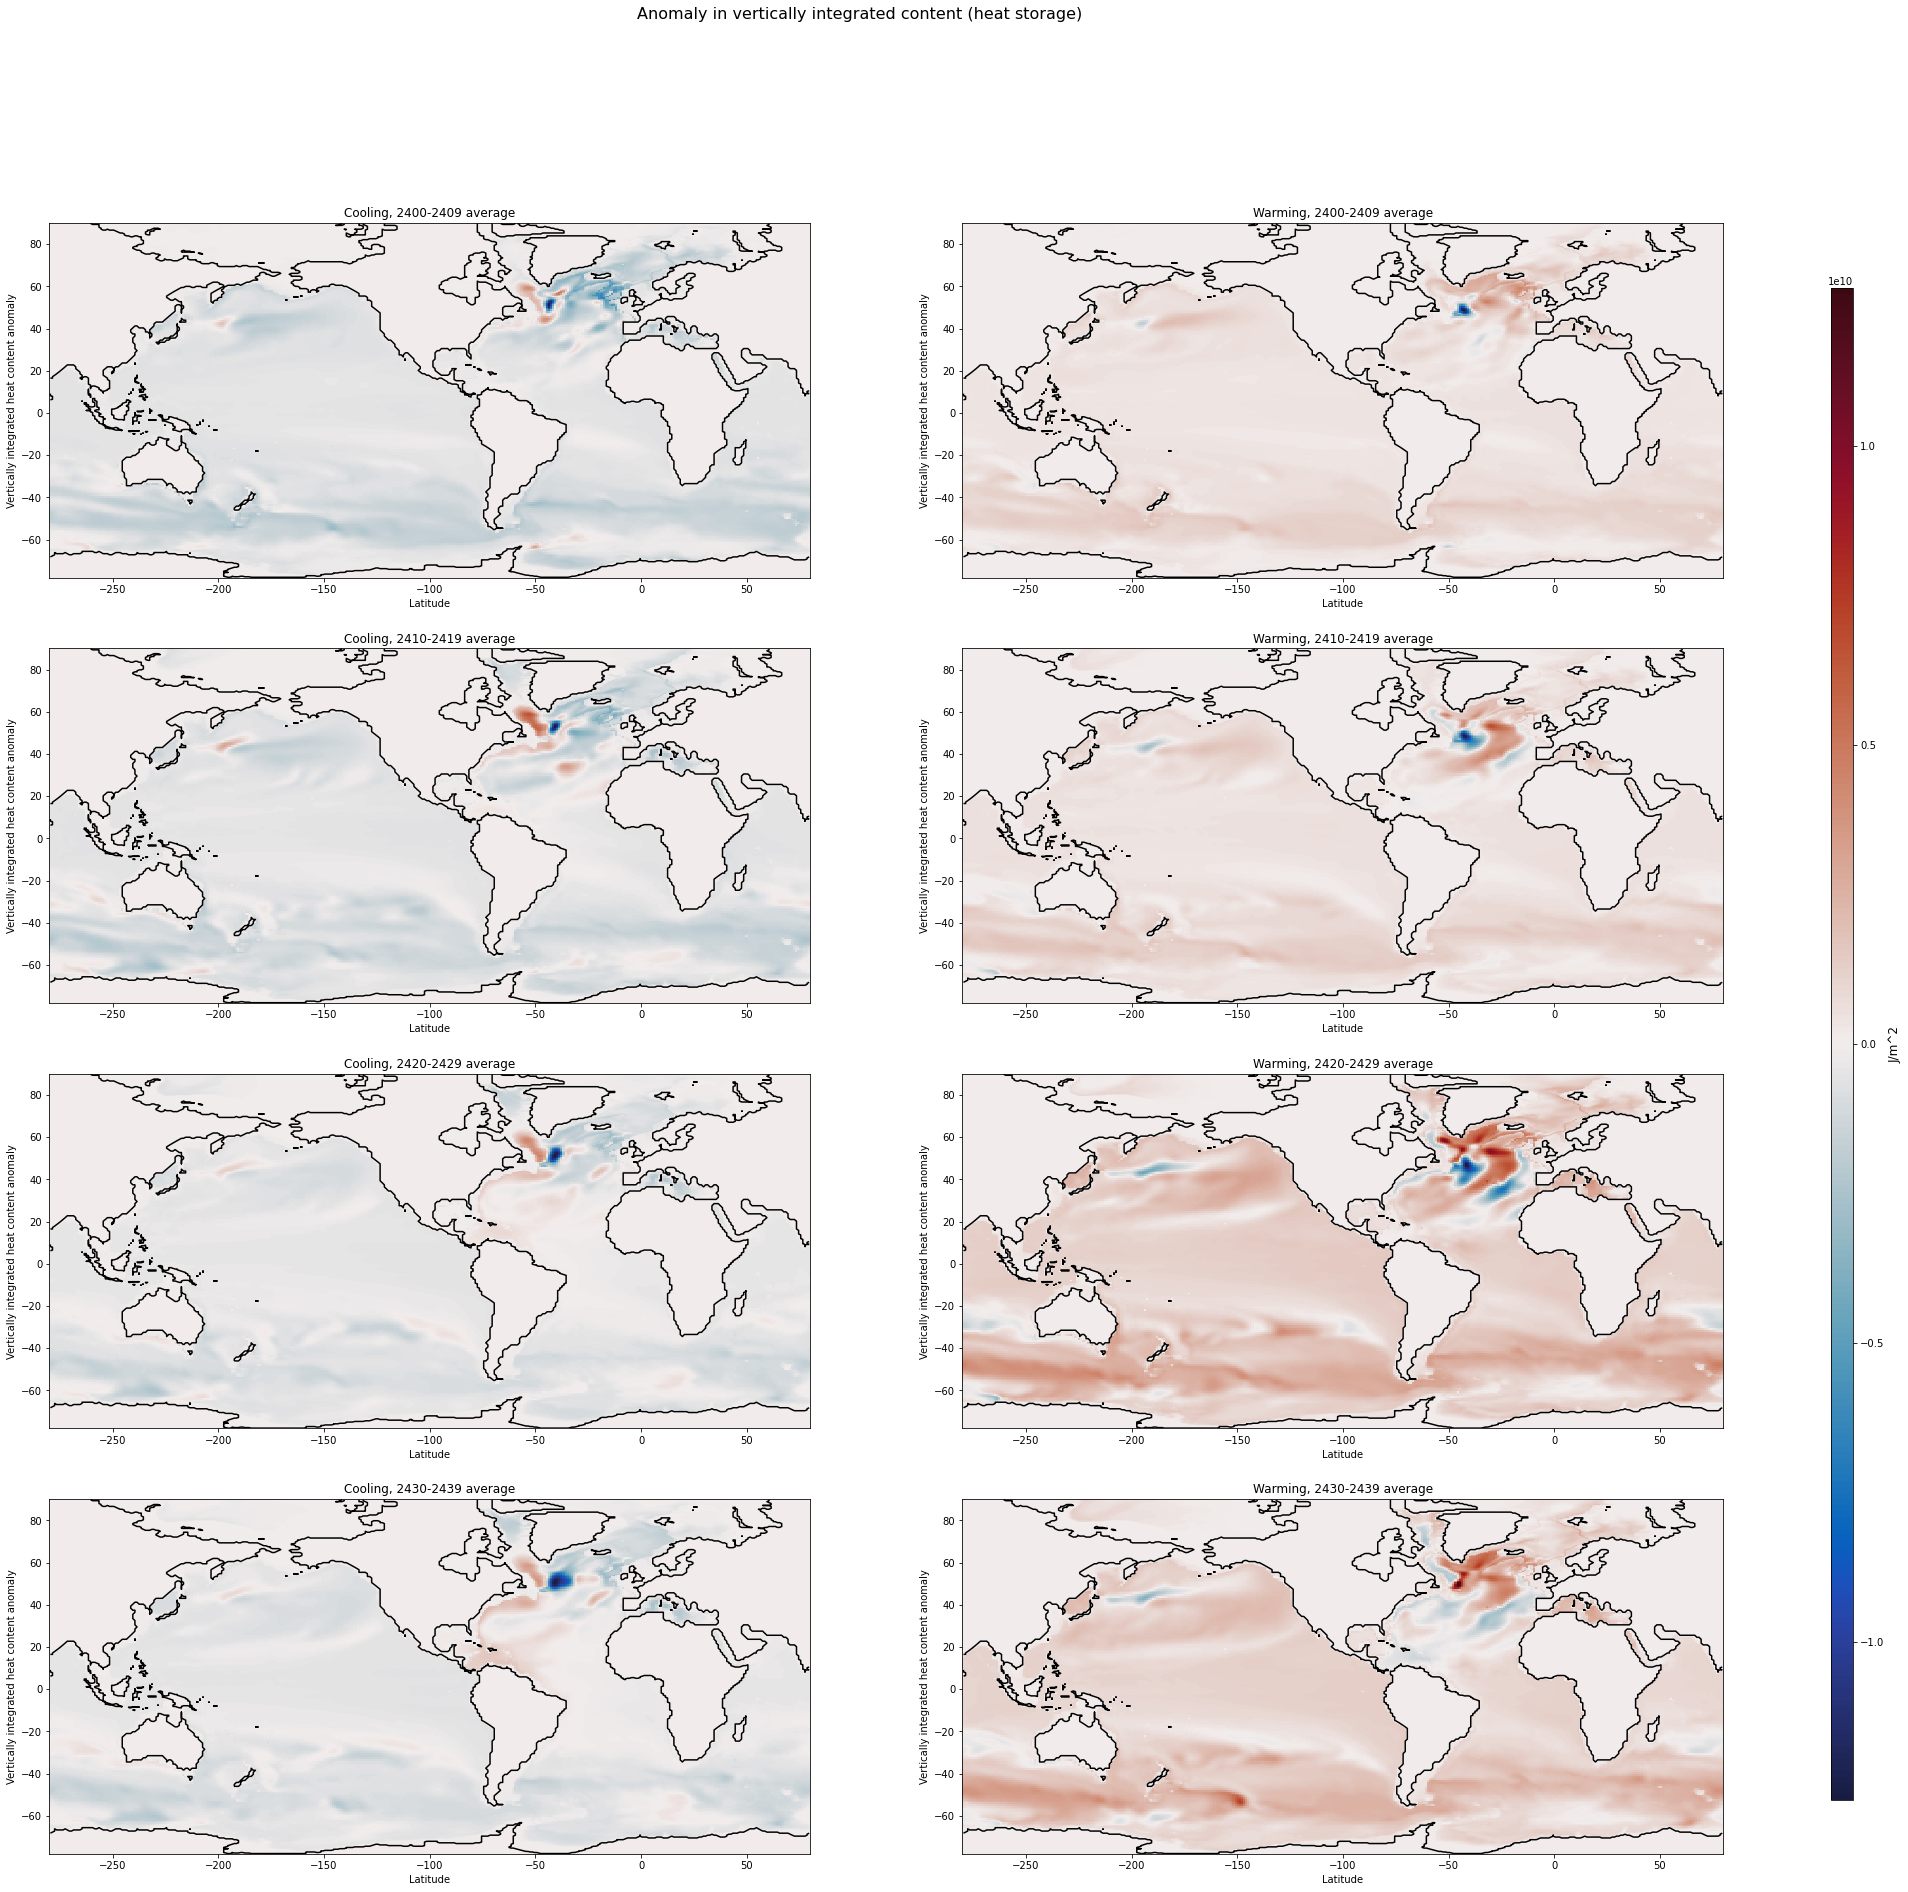

In [86]:
# Vertically integrated heat content time averages over different periods

### Would be good to plot side by sides for different decades,
# e.g., 2400-2410, 2410-2420, 2420-2430, 2430-2440.

fig, axs = plt.subplots(ncols = 2, nrows = 4, figsize = (30, 30))
plt.suptitle('Anomaly in vertically integrated heat content', fontsize=16)

yr_beg = '2400-01-01'
yr_end = '2409-12-31'
(vertically_integrated_heat_cool - vertically_integrated_heat_cont).sel(time=slice(yr_beg, yr_end)).mean('time').plot(ax = axs[0, 0], label = 'cooling', cmap = cm.cm.balance, add_colorbar = False)
mask_array.plot.contour(colors = 'k', levels = [2], ax = axs[0, 0])
axs[0, 0].set_title('Cooling, 2400-2409 average', fontsize=12)
axs[0, 0].set_ylabel('Longitude')
axs[0, 0].set_xlabel('Latitude')
(vertically_integrated_heat_warm - vertically_integrated_heat_cont).sel(time=slice(yr_beg, yr_end)).mean('time').plot(ax = axs[0, 1], label = 'warming', cmap = cm.cm.balance, add_colorbar = False)
mask_array.plot.contour(colors = 'k', levels = [2], ax = axs[0, 1])
axs[0, 1].set_title('Warming, 2400-2409 average', fontsize=12)
axs[0, 1].set_ylabel('Longitude')
axs[0, 1].set_xlabel('Latitude')

yr_beg = '2410-01-01'
yr_end = '2419-12-31'
(vertically_integrated_heat_cool - vertically_integrated_heat_cont).sel(time=slice(yr_beg, yr_end)).mean('time').plot(ax = axs[1, 0], label = 'cooling', cmap = cm.cm.balance, add_colorbar = False)
mask_array.plot.contour(colors = 'k', levels = [2], ax = axs[1, 0])
axs[1, 0].set_title('Cooling, 2410-2419 average', fontsize=12)
axs[1, 0].set_ylabel('Longitude')
axs[1, 0].set_xlabel('Latitude')
(vertically_integrated_heat_warm - vertically_integrated_heat_cont).sel(time=slice(yr_beg, yr_end)).mean('time').plot(ax = axs[1, 1], label = 'warming', cmap = cm.cm.balance, add_colorbar = False)
mask_array.plot.contour(colors = 'k', levels = [2], ax = axs[1, 1])
axs[1, 1].set_title('Warming, 2410-2419 average', fontsize=12)
axs[1, 1].set_ylabel('Longitude')
axs[1, 1].set_xlabel('Latitude')

yr_beg = '2420-01-01'
yr_end = '2429-12-31'
(vertically_integrated_heat_cool - vertically_integrated_heat_cont).sel(time=slice(yr_beg, yr_end)).mean('time').plot(ax = axs[2, 0], label = 'cooling', cmap = cm.cm.balance, add_colorbar = False)
mask_array.plot.contour(colors = 'k', levels = [2], ax = axs[2, 0])
axs[2, 0].set_title('Cooling, 2420-2429 average', fontsize=12)
axs[2, 0].set_ylabel('Longitude')
axs[2, 0].set_xlabel('Latitude')
(vertically_integrated_heat_warm - vertically_integrated_heat_cont).sel(time=slice(yr_beg, yr_end)).mean('time').plot(ax = axs[2, 1], label = 'warming', cmap = cm.cm.balance, add_colorbar = False)
mask_array.plot.contour(colors = 'k', levels = [2], ax = axs[2, 1])
axs[2, 1].set_title('Warming, 2420-2429 average', fontsize=12)
axs[2, 1].set_ylabel('Longitude')
axs[2, 1].set_xlabel('Latitude')

yr_beg = '2430-01-01'
yr_end = '2439-12-31'
(vertically_integrated_heat_cool - vertically_integrated_heat_cont).sel(time=slice(yr_beg, yr_end)).mean('time').plot(ax = axs[3, 0], label = 'cooling', cmap = cm.cm.balance, add_colorbar = False)
mask_array.plot.contour(colors = 'k', levels = [2], ax = axs[3, 0])
axs[3, 0].set_title('Cooling, 2430-2439 average', fontsize=12)
axs[3, 0].set_ylabel('Longitude')
axs[3, 0].set_xlabel('Latitude')
cbar_plot = (vertically_integrated_heat_warm - vertically_integrated_heat_cont).sel(time=slice(yr_beg, yr_end)).mean('time').plot(ax = axs[3, 1], label = 'warming', cmap = cm.cm.balance, add_colorbar = False)
mask_array.plot.contour(colors = 'k', levels = [2], ax = axs[3, 1])
axs[3, 1].set_title('Warming, 2430-2439 average', fontsize=12)
axs[3, 1].set_ylabel('Longitude')
axs[3, 1].set_xlabel('Latitude')

cb_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
cbar = fig.colorbar(cbar_plot, cax = cb_ax)
cbar.ax.set_ylabel('J/m^2', fontsize = 12)

#plt.savefig('heat_content_anomalies.jpg')

Text(0, 0.5, 'J/m^2')

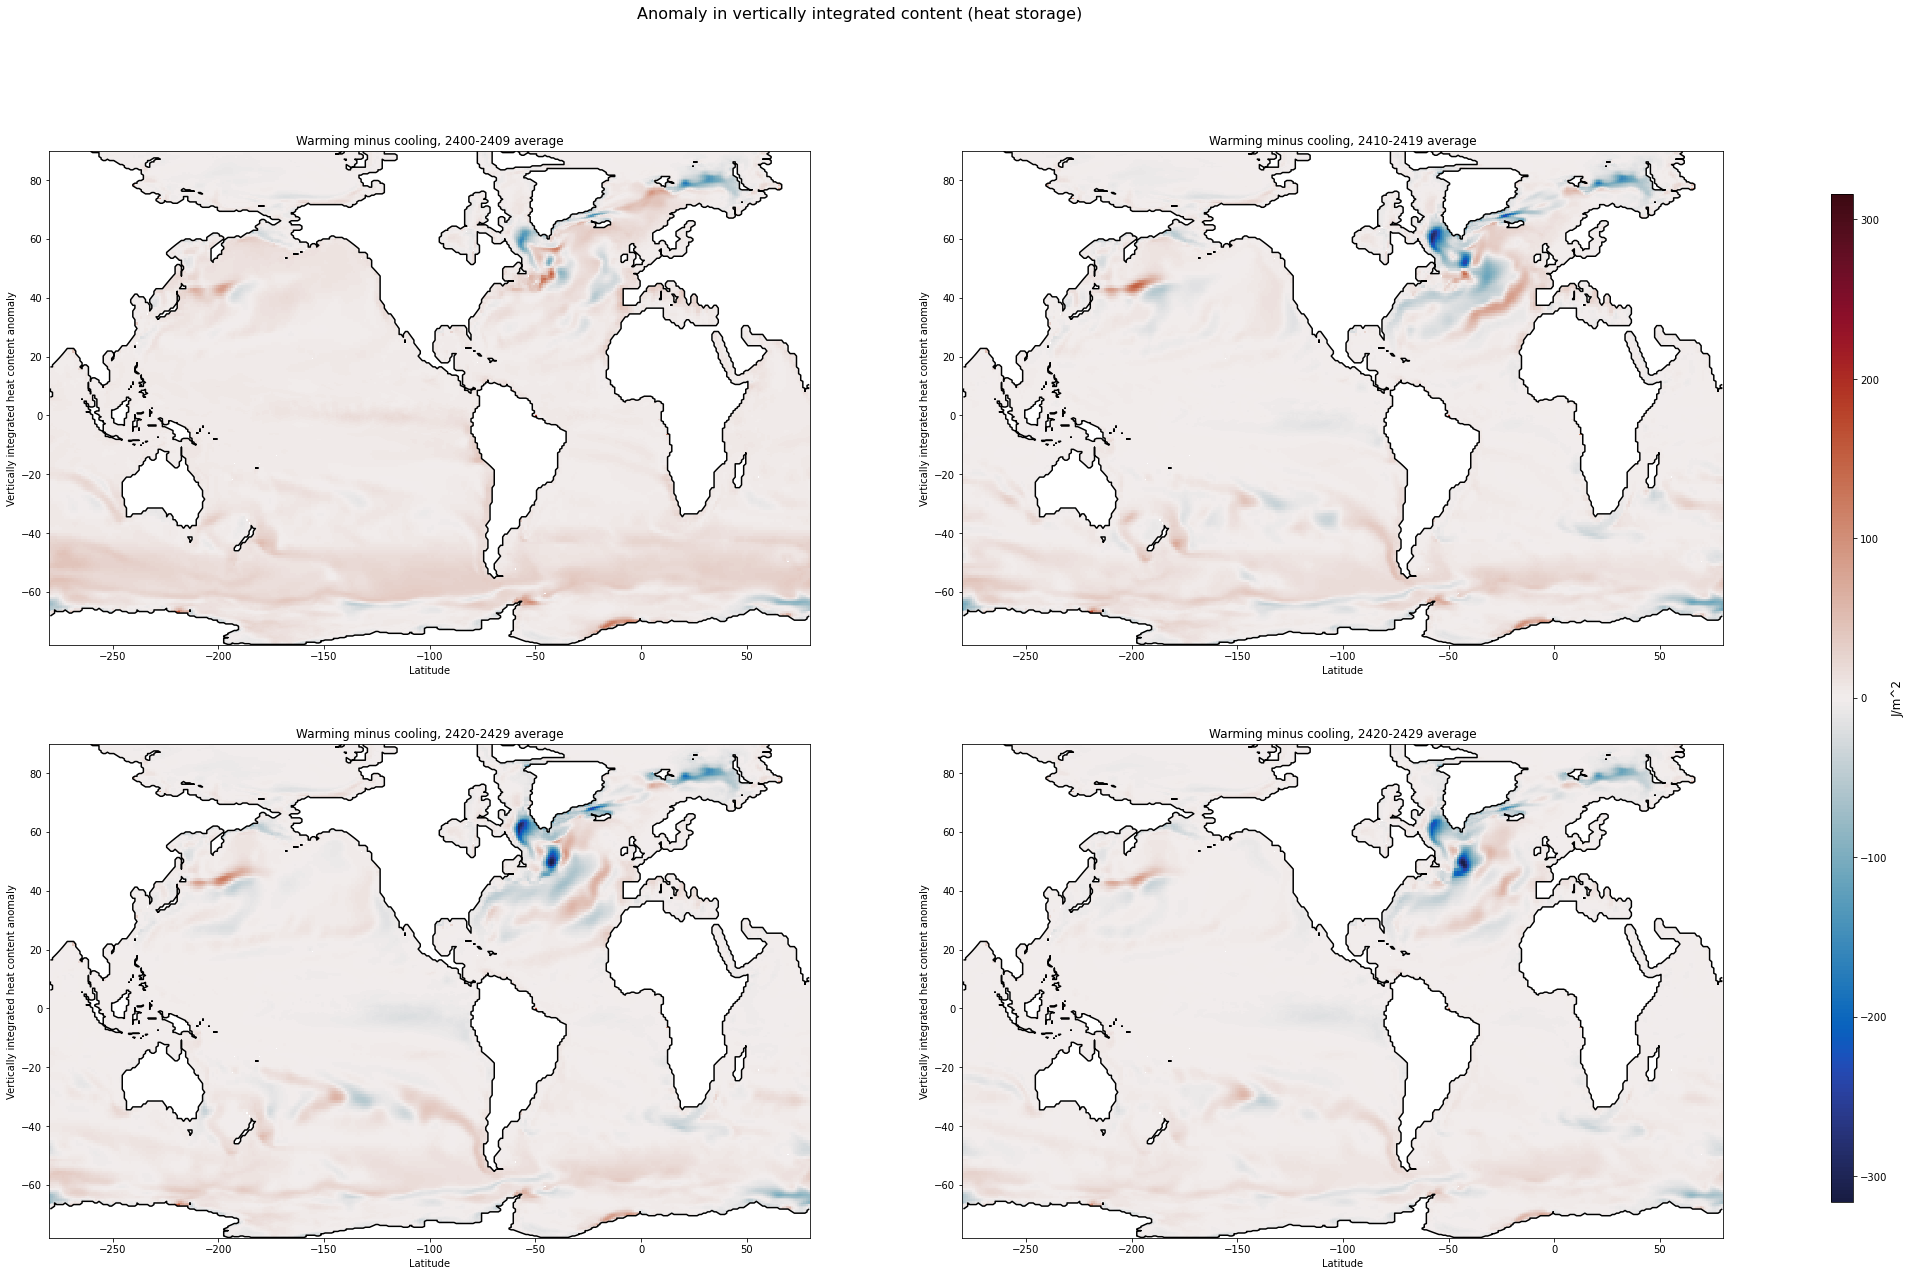

In [88]:
# Vertically integrated heat content time averages over different periods

### Would be good to plot side by sides for different decades,
# e.g., 2400-2410, 2410-2420, 2420-2430, 2430-2440.

fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (30, 20))
plt.suptitle('Anomaly in vertically integrated content (heat storage)', fontsize=16)

yr_beg = '2400-01-01'
yr_end = '2409-12-31'
difference = (net_sfc_warm - net_sfc_cool).sel(time=slice(yr_beg, yr_end)).mean('time')
difference.plot(ax = axs[0, 0], cmap = cm.cm.balance, add_colorbar = False)
mask_array.plot.contour(colors = 'k', levels = [2], ax = axs[0, 0])
axs[0, 0].set_title('Warming minus cooling, 2400-2409 average', fontsize=12)
axs[0, 0].set_ylabel('Vertically integrated heat content anomaly')
axs[0, 0].set_xlabel('Latitude')

yr_beg = '2410-01-01'
yr_end = '2419-12-31'
difference = (net_sfc_warm - net_sfc_cool).sel(time=slice(yr_beg, yr_end)).mean('time')
difference.plot(ax = axs[0, 1], cmap = cm.cm.balance, add_colorbar = False)
mask_array.plot.contour(colors = 'k', levels = [2], ax = axs[0, 1])
axs[0, 1].set_title('Warming minus cooling, 2410-2419 average', fontsize=12)
axs[0, 1].set_ylabel('Vertically integrated heat content anomaly')
axs[0, 1].set_xlabel('Latitude')

yr_beg = '2420-01-01'
yr_end = '2429-12-31'
difference = (net_sfc_warm - net_sfc_cool).sel(time=slice(yr_beg, yr_end)).mean('time')
difference.plot(ax = axs[1, 0], cmap = cm.cm.balance, add_colorbar = False)
mask_array.plot.contour(colors = 'k', levels = [2], ax = axs[1, 0])
axs[1, 0].set_title('Warming minus cooling, 2420-2429 average', fontsize=12)
axs[1, 0].set_ylabel('Vertically integrated heat content anomaly')
axs[1, 0].set_xlabel('Latitude')

yr_beg = '2430-01-01'
yr_end = '2439-12-31'
difference = (net_sfc_warm - net_sfc_cool).sel(time=slice(yr_beg, yr_end)).mean('time')
cbar_plot = difference.plot(ax = axs[1, 1], cmap = cm.cm.balance, add_colorbar = False)
mask_array.plot.contour(colors = 'k', levels = [2], ax = axs[1, 1])
axs[1, 1].set_title('Warming minus cooling, 2420-2429 average', fontsize=12)
axs[1, 1].set_ylabel('Vertically integrated heat content anomaly')
axs[1, 1].set_xlabel('Latitude')

cb_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
cbar = fig.colorbar(cbar_plot, cax = cb_ax)
cbar.ax.set_ylabel('J/m^2', fontsize = 12)

#plt.savefig('heat_content_anomaly_differences.jpg')